In [1]:
# stable pendulum

import numpy as np
from math import *

def control_trivial(theta, w):
    u = 2*m*g*sin(theta)
    return u
 
    
def env_pendulum(theta0,omega0,tau,m,g,l,numSteps, control=control_trivial):


    # initialize vectors
 
    time_vec = np.zeros(numSteps)
    theta_vec = np.zeros(numSteps)
    omega_vec = np.zeros(numSteps)
    u_vec = np.zeros(numSteps)
    #damage indicator
    damage_vec = np.zeros(numSteps)
 
    # set initial conditions
 
    theta = theta0
    omega = omega0
    time = 0
 
    # begin time-stepping
 
    for i in range(numSteps):
        omega_old = omega
        theta_old = theta
        u= control(theta, omega)
        # update the values
        omega = omega_old - (g/l)*sin(theta_old)*tau+(u/(m*l))*tau
        theta = theta_old + omega*tau
        # record the values
        time_vec[i] = tau*i
        omega_vec[i] = omega
        u_vec[i] = u
        #record and normalize theta to be in -pi to pi range
        theta_vec[i] = (((theta+np.pi) % (2*np.pi)) - np.pi)
        if 0<theta_vec[i]<np.pi/4:
            damage_vec[i]=1
    damge_perc=damage_vec.sum() * 100/numSteps
    return (damge_perc,time_vec,theta_vec,omega_vec,u_vec)

In [2]:
#parameters
theta0=3*np.pi/4
omega0=0
tau=0.01
m=1
g=10
l=1
numSteps=5000
    
damge_perc,time_vec,theta_vec,omega_vec,u_vec = env_pendulum(theta0,omega0,tau,m,g,l,numSteps)

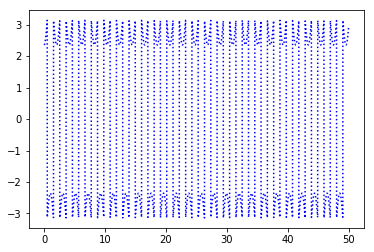

In [3]:
#plot the result
import matplotlib.pyplot as plt

#plot thetha
plt.plot(time_vec, theta_vec,":", label = "theta",color="blue")
plt.show()

In [ ]:
u_vec

In [ ]:
from pendulum.hellow_world import hello_world

In [ ]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

In [ ]:
total_data = np.vstack((theta_vec, omega_vec, u_vec)).T
Y= total_data[1:500,:2]
Z= total_data[:499,:] #-1 remember!

In [ ]:
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(Z, Y)

In [ ]:
gp.predict(total_data[98:99,:], return_cov=True)

In [ ]:
total_data[99]

In [ ]:
gp.predict(total_data[501:502,:], return_cov=True)

In [ ]:
total_data[502]

In [4]:
import cvxopt
from cvxopt import matrix

In [5]:
def cvxopt_solve_qp(P, q, G=None, h=None, A=None, b=None):
    #P = (P + P.T)  # make sure P is symmetric
    args = [matrix(P), matrix(q)]
    if G is not None:
        args.extend([matrix(G), matrix(h)])
        if A is not None:
            args.extend([matrix(A), matrix(b)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return numpy.array(sol['x']).reshape((P.shape[1],))

In [6]:
def A_clf(theta, w):
    return l*w

In [7]:
c=1 #gamma=c
def b_clf(theta, w):
    return -c*(0.5*m*l**2*w**2+m*g*l*(1-np.cos(theta)))

In [8]:
def A_sr(theta, w):
    return -(2*w)/(m*l)

In [9]:
delta_sr=10
def b_sr(theta, w):
    return -c*(delta_sr-w**2)-(2*g*sin(theta)*w)/(l)

In [10]:
theta_c=np.pi/4
delta_col=np.pi/8
def A_col(theta, w):
    return (2*w*(cos(theta-theta_c)-cos(delta_col)))/(m*l)

In [11]:
def b_col(theta, w):
    return -c*(cos(delta_col)-cos(theta-theta_c))*w**2-w**3*sin(theta-theta_c)+(2*g*w*sin(theta)*(cos(theta-theta_c)-cos(delta_col)))/l

In [12]:
def control_cbf_clf(theta, w):
    A_total=matrix(np.vstack([A_clf(theta, w),A_sr(theta, w),A_col(theta, w)]))
    b_total=np.vstack([b_clf(theta, w),b_sr(theta, w),b_col(theta, w)])
    P = matrix([[1.]])
    q = matrix([0.])
    u=cvxopt_solve_qp(P, q,A_total,b_total)
    return u

In [14]:
damge_perc,time_vec,theta_vec,omega_vec,u_vec=env_pendulum(theta0,omega0,tau,m,g,l,numSteps, control=control_cbf_clf)

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  4.1849e+02  1e+02  2e+00  0e+00
 1:  0.0000e+00  5.9664e+03  1e+02  1e+00  0e+00
 2:  0.0000e+00  9.8659e+06  2e+02  1e+00  0e+00
 3:  0.0000e+00  1.6674e+12  1e+05  1e+00  0e+00
 4:  0.0000e+00  2.8179e+19  2e+10  1e+00  0e+00
 5:  0.0000e+00  4.7624e+28  3e+17  1e+00  0e+00
 6:  0.0000e+00  8.0485e+39  5e+26  1e+00  0e+00
 7:  0.0000e+00  1.3585e+53  8e+37  1e+00  0e+00
 8:  0.0000e+00  2.2446e+68  1e+51  1e+00  0e+00
 9:  0.0000e+00  2.6824e+102  2e+85  1e+00  0e+00
10:  0.0000e+00  5.4338e+134  3e+117  1e+00  0e+00
11:  0.0000e+00  1.1084e+165  6e+147  1e+00  0e+00
12:  0.0000e+00  2.2613e+193  3e+188  1e+00  0e+00
13:  0.0000e+00  1.6872e+198  2e+191  1e+00  0e+00
14:  0.0000e+00  6.7082e+203  8e+196  1e+00  0e+00
15:  0.0000e+00  3.6719e+209  4e+200  1e+00  0e+00
16:  0.0000e+00  5.0998e+221  4e+207  1e+00  0e+00
17:  0.0000e+00  7.1246e+235  5e+219  1e+00  0e+00
18:  0.0000e+00  1.7721e+261  1e+245  1e+00  0e+00
19

ValueError: domain error

In [27]:
A_total=np.matrix(np.vstack([A_clf(1, 1),A_sr(1, 1),A_col(1, 1)]))

In [8]:
A_total

NameError: name 'A_total' is not defined

In [13]:
from bayes_cbf.pendulum import *

ERROR:root:Line magic function `%autoreload` not found.


     pcost       dcost       gap    pres   dres
 0:  1.7407e-02  3.4815e+02  2e+01  1e+00  3e-17
 1:  7.7040e+00  7.3170e+03  4e+00  1e+00  0e+00
 2:  6.6938e+09 -6.4779e+09  1e+10  8e-15  7e-11
 3:  1.0069e+09 -9.2313e+08  2e+09  7e-15  2e-11
 4:  1.5786e+08 -1.2471e+08  3e+08  1e-15  1e-11
 5:  2.7492e+07 -1.3655e+07  4e+07  5e-17  9e-13
 6:  6.1626e+06  3.8852e+05  6e+06  5e-17  5e-13
 7:  2.3304e+06  1.6982e+06  6e+05  6e-16  9e-13
 8:  1.7563e+06  1.7410e+06  2e+04  2e-17  7e-13
 9:  1.7412e+06  1.7410e+06  2e+02  7e-17  7e-13
10:  1.7410e+06  1.7410e+06  2e+00  2e-17  2e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.3202e+01  5.3510e+01  6e-01  8e-03  3e-13
 1:  5.3507e+01  5.3510e+01  6e-03  8e-05  2e-15
 2:  5.3510e+01  5.3510e+01  6e-05  8e-07  0e+00
 3:  5.3510e+01  5.3510e+01  6e-07  8e-09  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.2825e+01  5.3135e+01  6e-01  8e-03  2e-13
 1:  5.3132e+01  5.3135e

 1:  3.9361e+01  3.9364e+01  6e-03  1e-04  7e-15
 2:  3.9364e+01  3.9364e+01  6e-05  1e-06  2e-15
 3:  3.9364e+01  3.9364e+01  6e-07  1e-08  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.8966e+01  3.9299e+01  6e-01  1e-02  4e-13
 1:  3.9296e+01  3.9300e+01  6e-03  1e-04  7e-15
 2:  3.9299e+01  3.9300e+01  6e-05  1e-06  4e-15
 3:  3.9300e+01  3.9300e+01  6e-07  1e-08  4e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.8835e+01  3.9173e+01  6e-01  1e-02  6e-14
 1:  3.9170e+01  3.9173e+01  6e-03  1e-04  0e+00
 2:  3.9173e+01  3.9173e+01  6e-05  1e-06  4e-15
 3:  3.9173e+01  3.9173e+01  6e-07  1e-08  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.8637e+01  3.8979e+01  6e-01  1e-02  2e-14
 1:  3.8977e+01  3.8980e+01  6e-03  1e-04  0e+00
 2:  3.8980e+01  3.8980e+01  6e-05  1e-06  2e-15
 3:  3.8980e+01  3.8980e+01  6e-07  1e-08  0e+00
Optimal solution found.
     pcost       dcost   

 2:  2.6864e+01  2.6864e+01  6e-05  2e-06  9e-16
 3:  2.6864e+01  2.6864e+01  6e-07  2e-08  9e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.6683e+01  2.7030e+01  6e-01  2e-02  2e-13
 1:  2.7028e+01  2.7031e+01  6e-03  2e-04  4e-15
 2:  2.7031e+01  2.7031e+01  6e-05  2e-06  0e+00
 3:  2.7031e+01  2.7031e+01  6e-07  2e-08  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.6825e+01  2.7184e+01  6e-01  2e-02  3e-13
 1:  2.7182e+01  2.7185e+01  6e-03  2e-04  4e-15
 2:  2.7185e+01  2.7185e+01  6e-05  2e-06  2e-15
 3:  2.7185e+01  2.7185e+01  6e-07  2e-08  9e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.6949e+01  2.7319e+01  6e-01  2e-02  2e-13
 1:  2.7316e+01  2.7320e+01  6e-03  2e-04  2e-15
 2:  2.7320e+01  2.7320e+01  6e-05  2e-06  9e-16
 3:  2.7320e+01  2.7320e+01  6e-07  2e-08  3e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.7048e+01  2.7429e+0

 3:  1.7606e+01  1.7606e+01  7e-07  3e-08  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.7375e+01  1.7861e+01  7e-01  3e-02  4e-14
 1:  1.7860e+01  1.7865e+01  7e-03  3e-04  0e+00
 2:  1.7865e+01  1.7865e+01  7e-05  3e-06  2e-15
 3:  1.7865e+01  1.7865e+01  7e-07  3e-08  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.7608e+01  1.8119e+01  7e-01  3e-02  6e-14
 1:  1.8117e+01  1.8123e+01  7e-03  3e-04  0e+00
 2:  1.8123e+01  1.8123e+01  7e-05  3e-06  9e-16
 3:  1.8123e+01  1.8123e+01  7e-07  3e-08  9e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.7837e+01  1.8373e+01  7e-01  4e-02  7e-15
 1:  1.8372e+01  1.8377e+01  7e-03  4e-04  2e-15
 2:  1.8377e+01  1.8377e+01  7e-05  4e-06  9e-16
 3:  1.8377e+01  1.8377e+01  7e-07  4e-08  9e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.8060e+01  1.8621e+01  7e-01  4e-02  2e-14
 1:  1.8620e+01  1.8626e+0

     pcost       dcost       gap    pres   dres
 0:  3.6369e+00  2.6739e+02  2e+01  1e+00  4e-16
 1:  4.1528e+04 -1.2567e+04  5e+04  1e-15  1e-13
 2:  1.1089e+04  3.8763e+03  7e+03  2e-16  3e-14
 3:  5.6011e+03  5.0349e+03  6e+02  3e-17  0e+00
 4:  5.0546e+03  5.0492e+03  5e+00  4e-18  1e-14
 5:  5.0493e+03  5.0492e+03  5e-02  1e-16  0e+00
 6:  5.0492e+03  5.0492e+03  5e-04  8e-17  0e+00
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.5928e+01  1.2207e+02  9e+00  6e-01  2e-15
 1:  1.9206e+02  1.7325e+02  2e+01  2e-16  2e-14
 2:  1.7389e+02  1.7371e+02  2e-01  2e-16  0e+00
 3:  1.7371e+02  1.7371e+02  2e-03  2e-16  7e-15
 4:  1.7371e+02  1.7371e+02  2e-05  1e-16  4e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.3886e+01  1.3926e+02  1e+01  7e-01  0e+00
 1:  2.5957e+02  2.1963e+02  4e+01  1e-16  7e-15
 2:  2.2154e+02  2.2117e+02  4e-01  6e-17  4e-15
 3:  2.2117e+02  2.2117e+02  4e-03  1e-16  4e-15
 4:  2.2117e+02  2.2117e

 2:  3.3752e+01  3.3752e+01  6e-05  1e-06  4e-15
 3:  3.3752e+01  3.3752e+01  6e-07  1e-08  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.2851e+01  3.3204e+01  6e-01  1e-02  3e-13
 1:  3.3201e+01  3.3205e+01  6e-03  1e-04  2e-15
 2:  3.3205e+01  3.3205e+01  6e-05  1e-06  2e-15
 3:  3.3205e+01  3.3205e+01  6e-07  1e-08  5e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.2263e+01  3.2611e+01  6e-01  1e-02  3e-14
 1:  3.2608e+01  3.2612e+01  6e-03  1e-04  2e-15
 2:  3.2612e+01  3.2612e+01  6e-05  1e-06  2e-15
 3:  3.2612e+01  3.2612e+01  6e-07  1e-08  0e+00
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.1638e+01  3.1980e+01  6e-01  1e-02  3e-13
 1:  3.1977e+01  3.1981e+01  6e-03  1e-04  4e-15
 2:  3.1981e+01  3.1981e+01  6e-05  1e-06  3e-15
 3:  3.1981e+01  3.1981e+01  6e-07  1e-08  0e+00
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.0985e+01  3.1320e+0

 0:  6.1679e+00  6.4914e+00  6e-01  7e-02  2e-14
 1:  6.4918e+00  6.4956e+00  6e-03  7e-04  4e-16
 2:  6.4956e+00  6.4956e+00  6e-05  7e-06  4e-16
 3:  6.4956e+00  6.4956e+00  6e-07  7e-08  4e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.9828e+00  6.2928e+00  6e-01  7e-02  8e-15
 1:  6.2932e+00  6.2968e+00  6e-03  7e-04  4e-16
 2:  6.2968e+00  6.2968e+00  6e-05  7e-06  9e-16
 3:  6.2968e+00  6.2968e+00  6e-07  7e-08  4e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.8111e+00  6.1090e+00  5e-01  7e-02  8e-15
 1:  6.1093e+00  6.1128e+00  6e-03  7e-04  9e-16
 2:  6.1128e+00  6.1128e+00  6e-05  7e-06  2e-15
 3:  6.1128e+00  6.1128e+00  6e-07  7e-08  4e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.6524e+00  5.9395e+00  5e-01  7e-02  4e-15
 1:  5.9397e+00  5.9431e+00  5e-03  7e-04  0e+00
 2:  5.9431e+00  5.9431e+00  5e-05  7e-06  4e-16
 3:  5.9431e+00  5.9431e+00  5e-07  7e-08  9e-16


 0:  1.3593e+01  1.4088e+01  7e-01  4e-02  3e-15
 1:  1.4087e+01  1.4092e+01  7e-03  4e-04  0e+00
 2:  1.4092e+01  1.4092e+01  7e-05  4e-06  2e-15
 3:  1.4092e+01  1.4092e+01  7e-07  4e-08  0e+00
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.3856e+01  1.4382e+01  7e-01  4e-02  4e-14
 1:  1.4381e+01  1.4387e+01  7e-03  4e-04  9e-16
 2:  1.4387e+01  1.4387e+01  7e-05  4e-06  4e-15
 3:  1.4387e+01  1.4387e+01  7e-07  4e-08  3e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.4130e+01  1.4689e+01  7e-01  5e-02  2e-14
 1:  1.4689e+01  1.4695e+01  8e-03  5e-04  9e-16
 2:  1.4695e+01  1.4695e+01  8e-05  5e-06  2e-15
 3:  1.4695e+01  1.4695e+01  8e-07  5e-08  9e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.4414e+01  1.5009e+01  8e-01  5e-02  3e-14
 1:  1.5009e+01  1.5015e+01  8e-03  5e-04  2e-15
 2:  1.5015e+01  1.5015e+01  8e-05  5e-06  0e+00
 3:  1.5015e+01  1.5015e+01  8e-07  5e-08  0e+00


 1:  6.3374e+01  5.6582e+01  7e+00  2e-16  0e+00
 2:  5.6829e+01  5.6764e+01  6e-02  1e-17  2e-15
 3:  5.6765e+01  5.6764e+01  6e-04  4e-18  2e-15
 4:  5.6764e+01  5.6764e+01  6e-06  7e-17  7e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.2075e+01  4.0138e+01  5e+00  6e-01  9e-16
 1:  6.3204e+01  5.6254e+01  7e+00  5e-17  5e-15
 2:  5.6511e+01  5.6445e+01  7e-02  3e-17  2e-15
 3:  5.6446e+01  5.6445e+01  7e-04  8e-17  2e-15
 4:  5.6445e+01  5.6445e+01  7e-06  1e-16  0e+00
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.1823e+01  3.9686e+01  5e+00  6e-01  9e-16
 1:  6.3005e+01  5.5903e+01  7e+00  5e-17  2e-15
 2:  5.6170e+01  5.6103e+01  7e-02  2e-16  0e+00
 3:  5.6104e+01  5.6103e+01  7e-04  9e-17  0e+00
 4:  5.6103e+01  5.6103e+01  7e-06  1e-17  0e+00
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.1576e+01  3.9226e+01  5e+00  6e-01  2e-15
 1:  6.2772e+01  5.5527e+01  7e+00  5e-17  7e-15


 0:  8.9360e-01  1.1077e+00  5e-01  3e-01  2e-15
 1:  1.1089e+00  1.1204e+00  5e-03  7e-03  2e-16
 2:  1.1204e+00  1.1205e+00  5e-05  7e-05  9e-16
 3:  1.1205e+00  1.1205e+00  5e-07  7e-07  2e-16
 4:  1.1205e+00  1.1205e+00  5e-09  7e-09  9e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  8.7638e-01  1.0860e+00  5e-01  3e-01  2e-16
 1:  1.0870e+00  1.0985e+00  5e-03  8e-03  2e-16
 2:  1.0984e+00  1.0985e+00  5e-05  8e-05  7e-16
 3:  1.0985e+00  1.0985e+00  5e-07  8e-07  2e-16
 4:  1.0985e+00  1.0985e+00  5e-09  8e-09  4e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  8.6079e-01  1.0667e+00  5e-01  3e-01  1e-15
 1:  1.0676e+00  1.0790e+00  5e-03  8e-03  2e-16
 2:  1.0789e+00  1.0790e+00  5e-05  8e-05  4e-16
 3:  1.0790e+00  1.0790e+00  5e-07  8e-07  7e-16
 4:  1.0790e+00  1.0790e+00  5e-09  8e-09  0e+00
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  8.4677e-01  1.0498e+00  5e-01  3e-01  1e-15


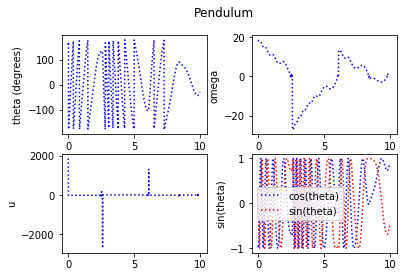

TypeError: 'NoneType' object is not iterable

In [11]:
(damge_perc,time_vec,theta_vec,omega_vec,u_vec) = run_pendulum_experiment(control=control_cbf_clf)

In [7]:
u_vec

NameError: name 'u_vec' is not defined